0. Описать задачу словами
1. Прочитать данные
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
3. Обработать пропущенные значения (или убедиться, что их нет)
4. Обработать категориальные признаки
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)
6. Разбить данные на обучающую и тестовую выборки
7. Запустить классификатор ближайших соседей (попробовать разное их количество)
8. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 
9. По желанию: запустить другие классификаторы. Сравнить результаты
10. По желанию: как-то побороться с несбалансированностью классов (если она есть)
11. По желанию: исключить коррелированные переменные (объяснить зачем)
12. Сделать общие выводы"

# Описание задачи

У компании N есть цель выбрать маркетинговую стратегию для повышения продаж продукта/услуги. Необходимо выявить эффективность каждой маркетинговой кампании на определенного потребителя.

Для решения данной задачи были собраны личные данные о потребителях (уровень образования, семейное положение, количество детей, доход), данные о поведении потребителя (траты на покупку определенной продукции, место покупки, жалобы), принятии потребителем определенного предложения (проводимым по пяти разным стратегиям + отдельно по текущей).

Задача сводится к задаче классификации: нужно предсказать, примет ли потребитель текущее предложение (1 - примет, 0 - не примет), в зависимости от определенного покупательского поведения и личных данных.

In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Чтение данных

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

In [3]:
data_raw = pd.read_csv('marketing_campaign.csv')

In [4]:
data_raw.shape

(2240, 29)

In [5]:
data_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
data_raw.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

##### Личные данные
- ID - номер клиента
- Year_Birth - год рождения клиента
- Education - уровень образования клиента
- Marital_Status - семейное положение клиента
- Income - доход клиента
- Kidhome - количество маленьких детей в семье
- Teenhome - количество подростков в семье
- Dt_Customer - дата регистрации клиента
- Recency - количество прошедших дней со дня последней покупки клиента
##### Траты на определенные продукты за 2 года
- MntWines - вино
- MntFruits - фрукты
- MntMeatProducts - мясо
- MntFishProducts - рыба
- MntSweetProducts - сладкое
- MntGoldProds - золотые изделия
##### Поведение потребителя
- NumDealsPurchases - количество покупок со скидкой
- NumWebPurchases - количество покупок через веб-сайт
- NumCatalogPurchases - количество покупок через каталог
- NumStorePurchases - количество покупок, совершенные в магазине
- NumWebVisitsMonth - Количество посещений веб-сайта за последний месяц
##### Ответ на предложения по определенным маркетинговым кампаниям (1 - принял, 0 - не принял)
- AcceptedCmp3
- AcceptedCmp4
- AcceptedCmp5
- AcceptedCmp1
- AcceptedCmp2
##### Жалобы
- Complain - 1, если клиент жаловался в последние 2 года
##### Пока неизвестные признаки
- Z_CostContact - неизвестный признак
- Z_Revenue - неизвестный признак
##### Ответ на текущее предложение
- Response - 1, если клиент принял предложение по последней рекламной акции, иначе 0

#### Приведем к соответствию типы признаков

In [7]:
data_raw.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Категориальные признаки:

In [8]:
data_raw['Education'] = data_raw['Education'].astype('category')
data_raw['Marital_Status'] = data_raw['Marital_Status'].astype('category')
data_raw['AcceptedCmp1'] = data_raw['AcceptedCmp1'].astype('category')
data_raw['AcceptedCmp2'] = data_raw['AcceptedCmp2'].astype('category')
data_raw['AcceptedCmp3'] = data_raw['AcceptedCmp3'].astype('category')
data_raw['AcceptedCmp4'] = data_raw['AcceptedCmp4'].astype('category')
data_raw['AcceptedCmp5'] = data_raw['AcceptedCmp5'].astype('category')
data_raw['Response'] = data_raw['Response'].astype('category')
data_raw['Complain'] = data_raw['Complain'].astype('category')

Дата:

In [9]:
data_raw['Dt_Customer'] = pd.to_datetime(data_raw['Dt_Customer'])
data_raw['Year_Birth'] = pd.to_datetime(data_raw['Year_Birth'], format="%Y")

In [10]:
data_raw.dtypes

ID                              int64
Year_Birth             datetime64[ns]
Education                    category
Marital_Status               category
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                 category
AcceptedCmp4                 category
AcceptedCmp5                 category
AcceptedCmp1                 category
AcceptedCmp2                 category
Complain                     category
Z_CostContac

Проверим пропущенные значения в датасете.

In [18]:
data_raw.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

# Визуализация данных

In [11]:
data_raw.describe()

,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,5592.159821,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,3.0,11.0
std,3246.662198,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.0,0.0
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,2828.250000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,5458.500000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,8427.750000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,11191.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0


In [12]:
data_raw.describe().shape

(8, 18)

При беглом осмотре можно заключить, что два признака (Z_CostContact и Z_Revenue) для всех строк имеют одно и то же значение: 3 и 11 соответственно. Избавимся от них, так как на модель они не повлияют.

Номер ID не нужен для дальнейшего анализа данных. Уберем признак.

In [13]:
data = data_raw.drop(['Z_CostContact', 'Z_Revenue'], axis=1)
data = data.drop(columns='ID')

In [14]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518
std,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


In [15]:
data.describe(include=['category'])

,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2240,2240,2240,2240,2240,2240,2240,2240,2240
unique,5,8,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0
freq,1127,864,2077,2073,2077,2096,2210,2219,1906


Максимум в признаке Income слишком отличается от среднего. Возможно, стоит избавиться от них. Проверим значения кванителей.

In [21]:
data['Income'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      7500.00
0.010      7579.20
0.050     18985.50
0.100     24117.50
0.500     51381.50
0.900     79844.00
0.950     84130.00
0.990     94458.80
0.995    102145.75
Name: Income, dtype: float64

In [16]:
data['Education'].dtype

CategoricalDtype(categories=['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'], ordered=False)

No handles with labels found to put in legend.


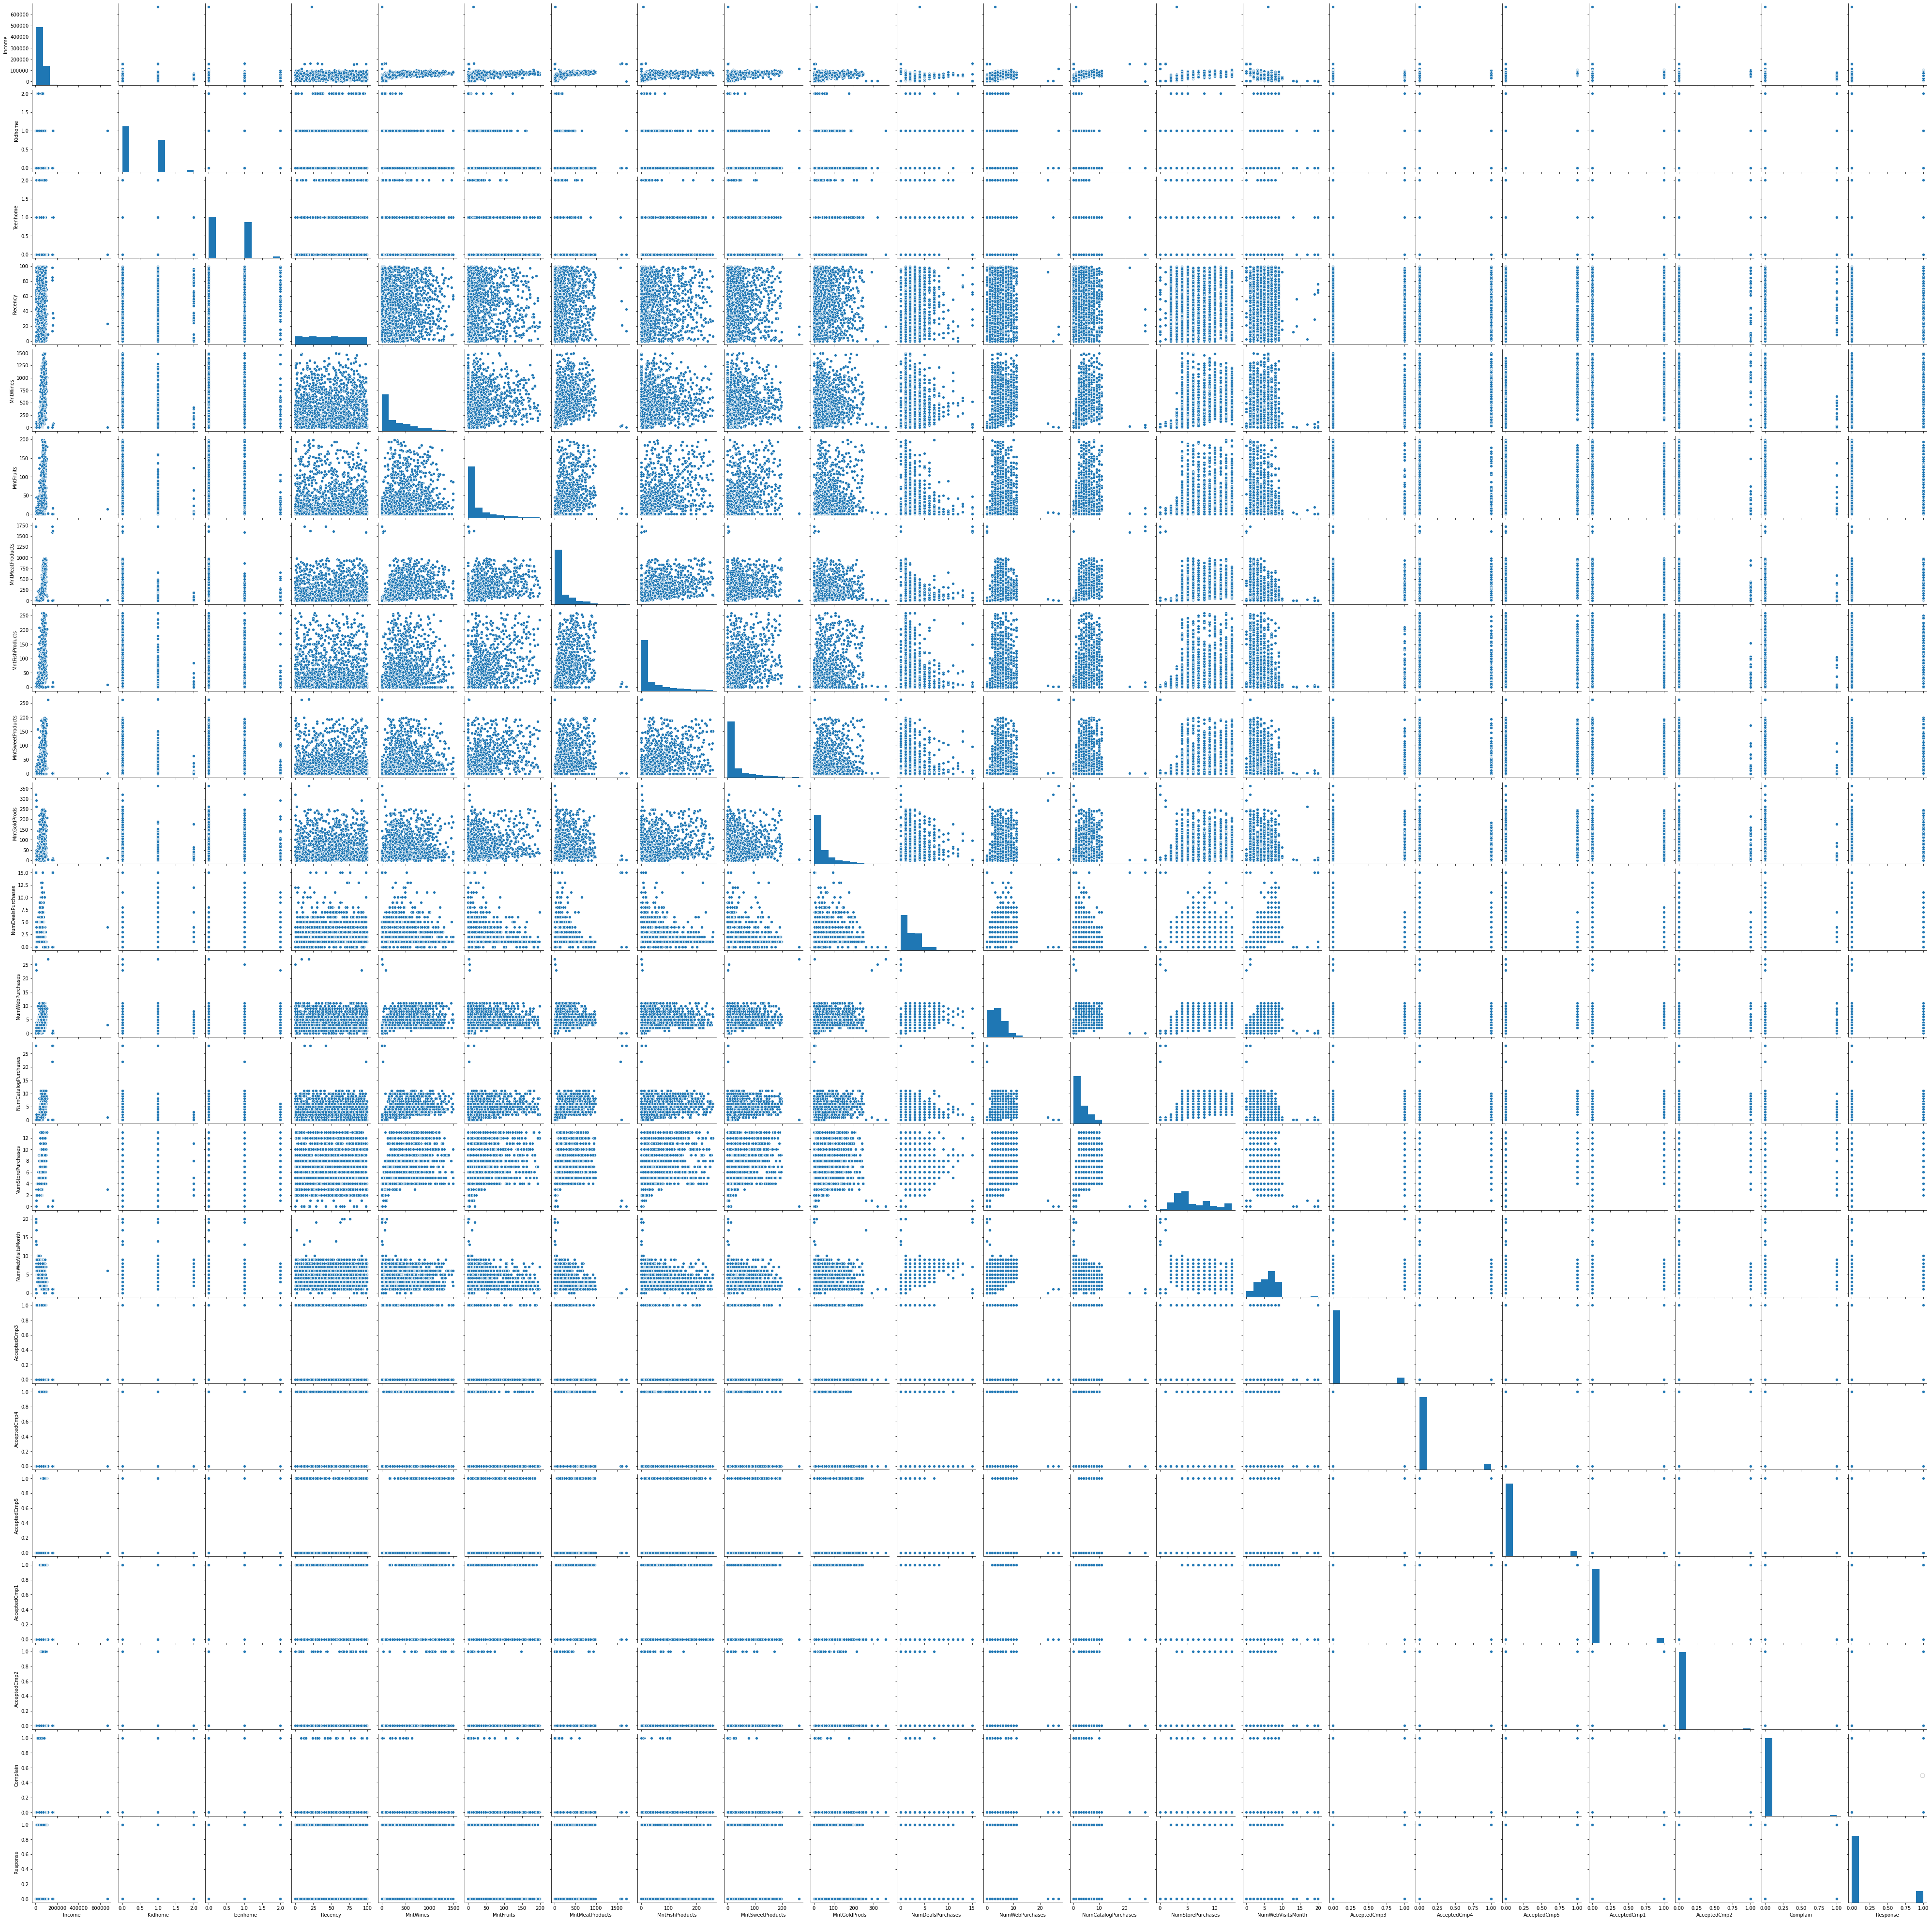

In [20]:
sns.pairplot(data, diag_kind='hist')
plt.legend()
pass